### 📚 **IEEE ECCE2025 Tutorial 16: Reimagine Power Electronics Design with AI**  
---
Welcome to the official code repository for the IEEE ECCE2025 Tutorial 16:

> **Reimagine Power Electronics Design with AI: Opportunities and Challenges Ahead**

#### 🎤 **Speakers**
1. **Xinze Li**  
   University of Arkansas  
2. **Peter Wilson**  
   University of Bath
3. **Fanfan Lin**  
   Zhejiang University–University of Illinois Urbana-Champaign Institute (ZJUI)

---

#### 👨‍💻 **Code Author**
- **Xinze Li**  
  University of Arkansas  
  *Contact: xinzel@uark.edu*

---

*We hope you enjoy the tutorial and find the resources helpful!*


## Section 1. Install Python Dependencies

* Following the index from 1 onwards
* Recommended method: use `pip` to install dependencies.
* If running in Google Colab, you can use a code cell with `!pip install ...` to install missing packages.


In [1]:
!git clone https://github.com/XinzeLee/ECCE2025 /content/ECCE2025
# change current working directory
%cd /content/ECCE2025

# If requirements.txt is already in your working directory
!pip install -r requirements.txt

Cloning into '/content/ECCE2025'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 58 (delta 24), reused 44 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 4.08 MiB | 24.56 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/ECCE2025
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 2.3 MB/s eta 0:00:00


# [While Installing Packages... Let's Look at the Dataset First. Click here <<<](https://github.com/XinzeLee/ECCE2025/blob/main/DAB_TPS.csv)

## Section 2. Load and Explore Your Data
    2.1 Load Data: Import your dataset and implement basic data cleaning.

    2.2 Feature Selection: Use Power Electronics Insights, Correlation Map, and Principal Component Analysis to identify key features.

    2.3 t-SNE: Visualize high-dimensional data and reveal latent manifolds.    

#### Section 2.1 Load Data: Import the DAB dataset and implement basic data cleaning

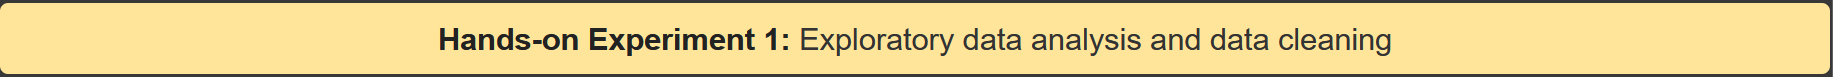

<ul style="background-color:#25e599; padding:10px; border-radius:5px; text-align:left; font-size:1.2em;">
  <b style="color:#222222;">Learning Objectives:</b>
  <li style="color:#333333;">1. Input feature selection</li>
  <li style="color:#333333;">2. Data cleaning with power electronics insights</li>
</ul>

In [2]:
#------------------------------------------------------------------------------------------------
# Conduct basic data cleaning
# TODO: Hands-on Experiment 1 - Remove outliers and/or filter by total_ZVS
#------------------------------------------------------------------------------------------------

import pandas as pd
import numpy as np

# Flag to control whether to apply outlier exclusion and total_ZVS filtering
# Set to False to skip both outlier and total_ZVS filtering
# @title  {"form-width":"40%"}
apply_data_filtering = True # @param ["True","False"] {"type":"raw"}
# @markdown ### - Comments
# @markdown
# @markdown  - **Understand the dataset** with various exploratory data analysis methods
# @markdown  - **Independent input features:** `P`, `Vref`, `D1`, `D2`
# @markdown    - Independent input features are selected based on:
# @markdown      1. **PE insights** – `P`, `Vin`, `Vref`, `D1`, `D2` follow an equality constraint
# @markdown      2. **Correlation map analysis** (focus on `D0` row)
# @markdown      3. **Principal component analysis** for further validation
# @markdown  - **Basic data cleaning:** filter out data with odd number of ZVS devices (ensures symmetry in `iL` waveform in steady state)
# @markdown
# @markdown
# @markdown ### Jargon Explained
# @markdown
# @markdown - **Correlation map:** Quantizes the relationship between input and output features based on the correlation matrix
# @markdown - **Histogram:** Visualizes the distribution of data by showing the frequency of data points within defined intervals (bins)

# Load the CSV file
df = pd.read_csv("DAB_TPS.csv", index_col=0)

# Print initial shape
print("Initial shape:", df.shape)

# Filter out data where "Validity" column is 0
df_filtered = df[df['Validity'] != 0]
print("Shape after Validity filtering:", df_filtered.shape)

# Sum the specified columns
sum_columns = ["vp_t1", "vp_t2", "vp_t3", "vp_t4", "vs_t1", "vs_t2", "vs_t3", "vs_t4"]
df_filtered['total_ZVS'] = df_filtered[sum_columns].sum(axis=1)

if apply_data_filtering:
    # Filter out samples with odd sum values
    df_intermediate = df_filtered[df_filtered['total_ZVS'] % 2 == 0]
    print("Shape after total_ZVS even filtering:", df_intermediate.shape)

    # Analyze outliers in the 'ipk2pk' feature
    ipk2pk = df_intermediate['ipk2pk']
    mean_ipk2pk = ipk2pk.mean()
    std_ipk2pk = ipk2pk.std()

    # Define outlier threshold (e.g., 3 standard deviations from mean)
    upper_threshold = mean_ipk2pk + 3 * std_ipk2pk
    lower_threshold = mean_ipk2pk - 3 * std_ipk2pk

    # Identify outliers
    outliers = df_intermediate[(ipk2pk > upper_threshold) | (ipk2pk < lower_threshold)]

    print(f"ipk2pk mean: {mean_ipk2pk:.3f}, std: {std_ipk2pk:.3f}")
    print(f"Outlier threshold: < {lower_threshold:.3f} or > {upper_threshold:.3f}")
    print(f"Number of outliers in ipk2pk: {outliers.shape[0]}")

    # Exclude outliers
    df_final = df_intermediate[(ipk2pk <= upper_threshold) & (ipk2pk >= lower_threshold)]
    print(f"Shape after outlier exclusion: {df_final.shape}")
else:
    print("total_ZVS and outlier filtering not applied.")
    df_final = df_filtered.copy()
    print(f"Shape after skipping total_ZVS and outlier filtering: {df_final.shape}")


Initial shape: (5291, 18)
Shape after Validity filtering: (5291, 18)
Shape after total_ZVS even filtering: (4633, 19)
ipk2pk mean: 13.303, std: 5.266
Outlier threshold: < -2.495 or > 29.102
Number of outliers in ipk2pk: 0
Shape after outlier exclusion: (4633, 19)


#### 2.2 Feature Selection: Identify key features for NN training
* Correlation map: Feature correlation
* Histogram: Visualize the distribution of input and output variables
* Principal Component Analysis: Guide the selection of main features

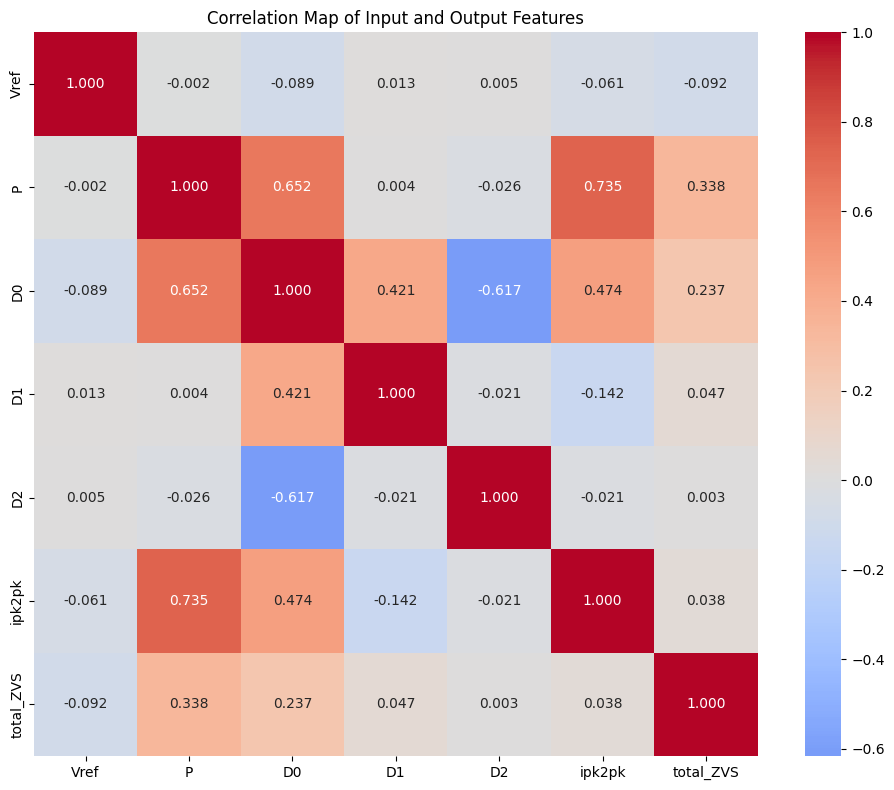

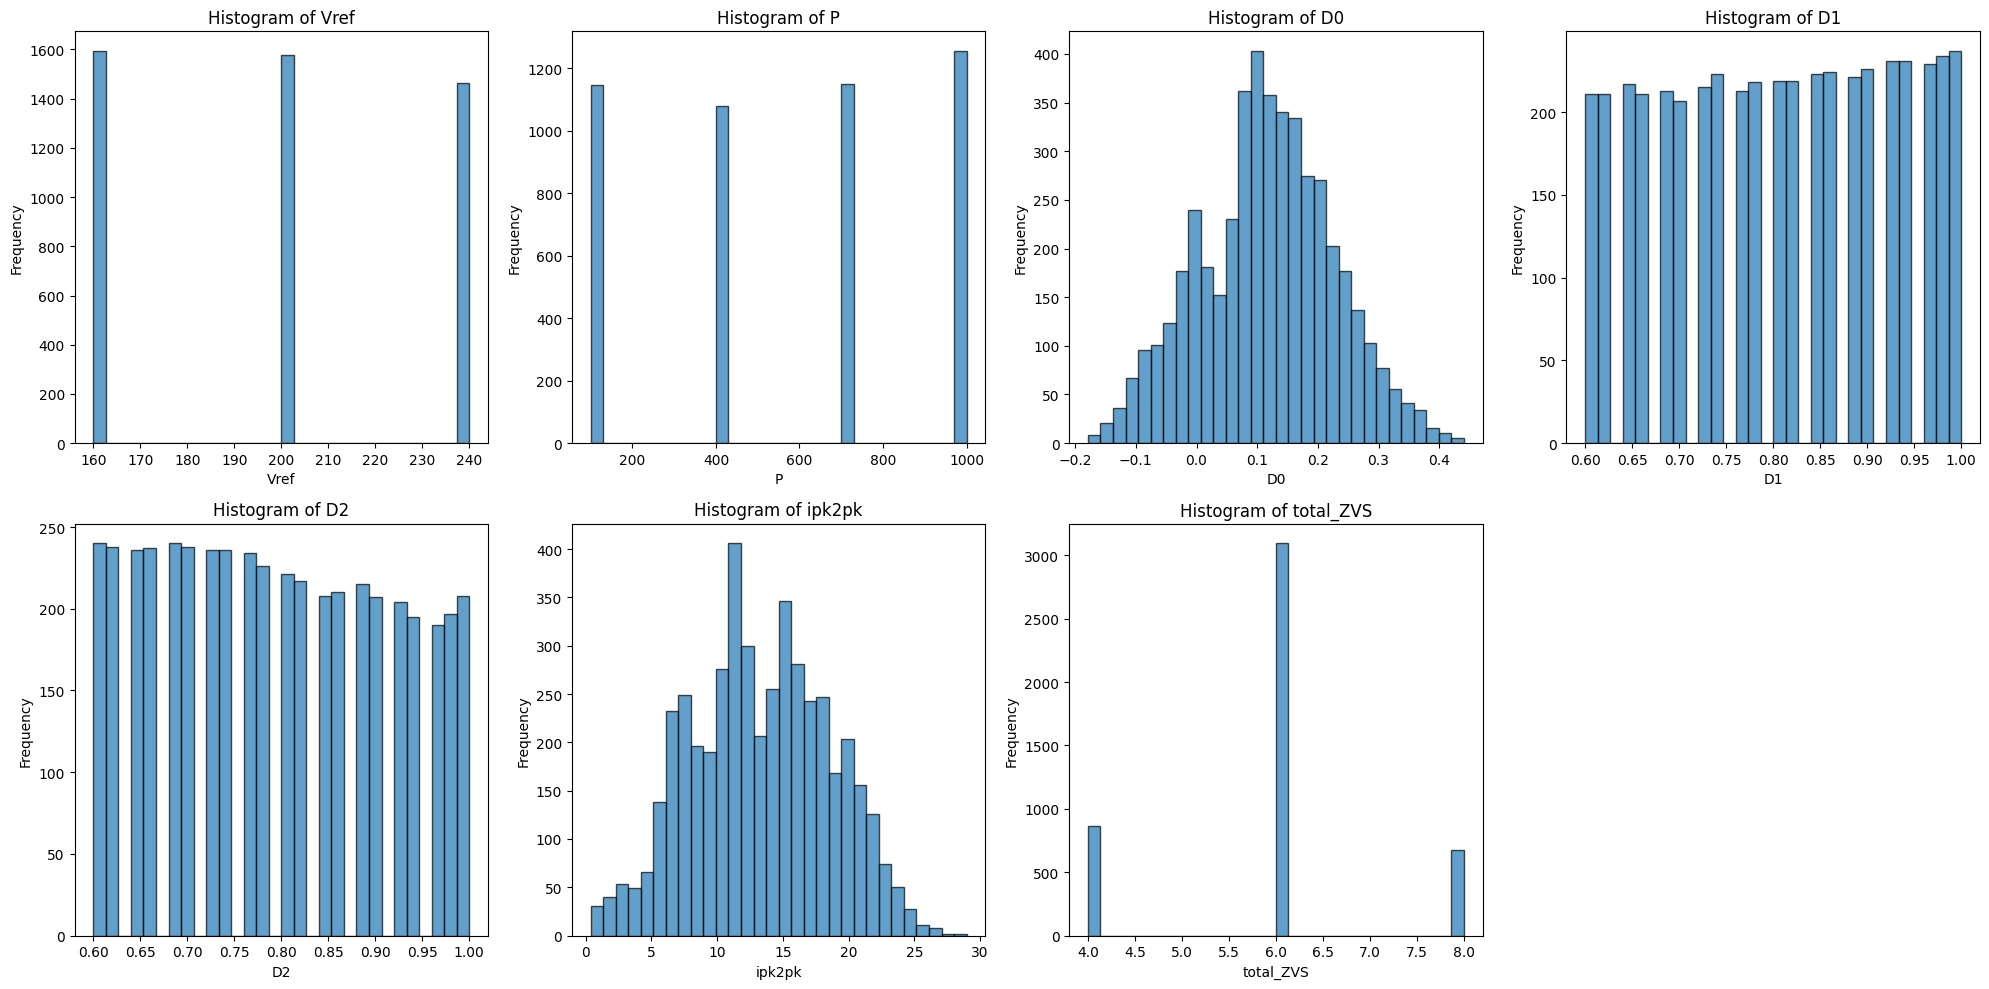

=== BASIC DATA ANALYSIS ===
Total number of samples: 4633

=== FEATURE STATISTICS ===
              Vref            P           D0           D1           D2  \
count  4633.000000  4633.000000  4633.000000  4633.000000  4633.000000   
mean    198.860350   562.788690     0.115350     0.804118     0.791604   
std      32.470202   340.236625     0.107296     0.121462     0.120520   
min     160.000000   100.000000    -0.178947     0.600000     0.600000   
25%     160.000000   400.000000     0.040641     0.700000     0.680000   
50%     200.000000   700.000000     0.119363     0.800000     0.780000   
75%     240.000000  1000.000000     0.181829     0.920000     0.900000   
max     240.000000  1000.000000     0.440729     1.000000     1.000000   

            ipk2pk    total_ZVS  
count  4633.000000  4633.000000  
mean     13.303469     5.915821  
std       5.266241     1.149751  
min       0.368701     4.000000  
25%       9.556965     6.000000  
50%      13.193537     6.000000  
75%      

In [3]:
#------------------------------------------------------------------------------------------------
# Conduct basic data analysis, including correlation map, histograms, feature ranges, etc., to guide the selection of main features
#------------------------------------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Define the features we want to analyze
input_features = ["Vref", "P", "D0", "D1", "D2"]
output_features = ["ipk2pk", "total_ZVS"]
all_features = input_features + output_features

# Import the functions to plot the correlation map, feature histograms, and basic statistical analysis
from utils import plot_correlation_map, plot_feature_histograms, basic_statistical_analysis

# 1. Correlation Map
plot_correlation_map(df_final, all_features)

# 2. Histograms for each feature
plot_feature_histograms(df_final, all_features)

# 3. Basic Statistical Analysis
basic_statistical_analysis(df_final, all_features)


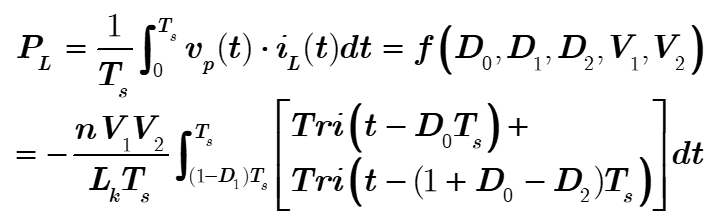

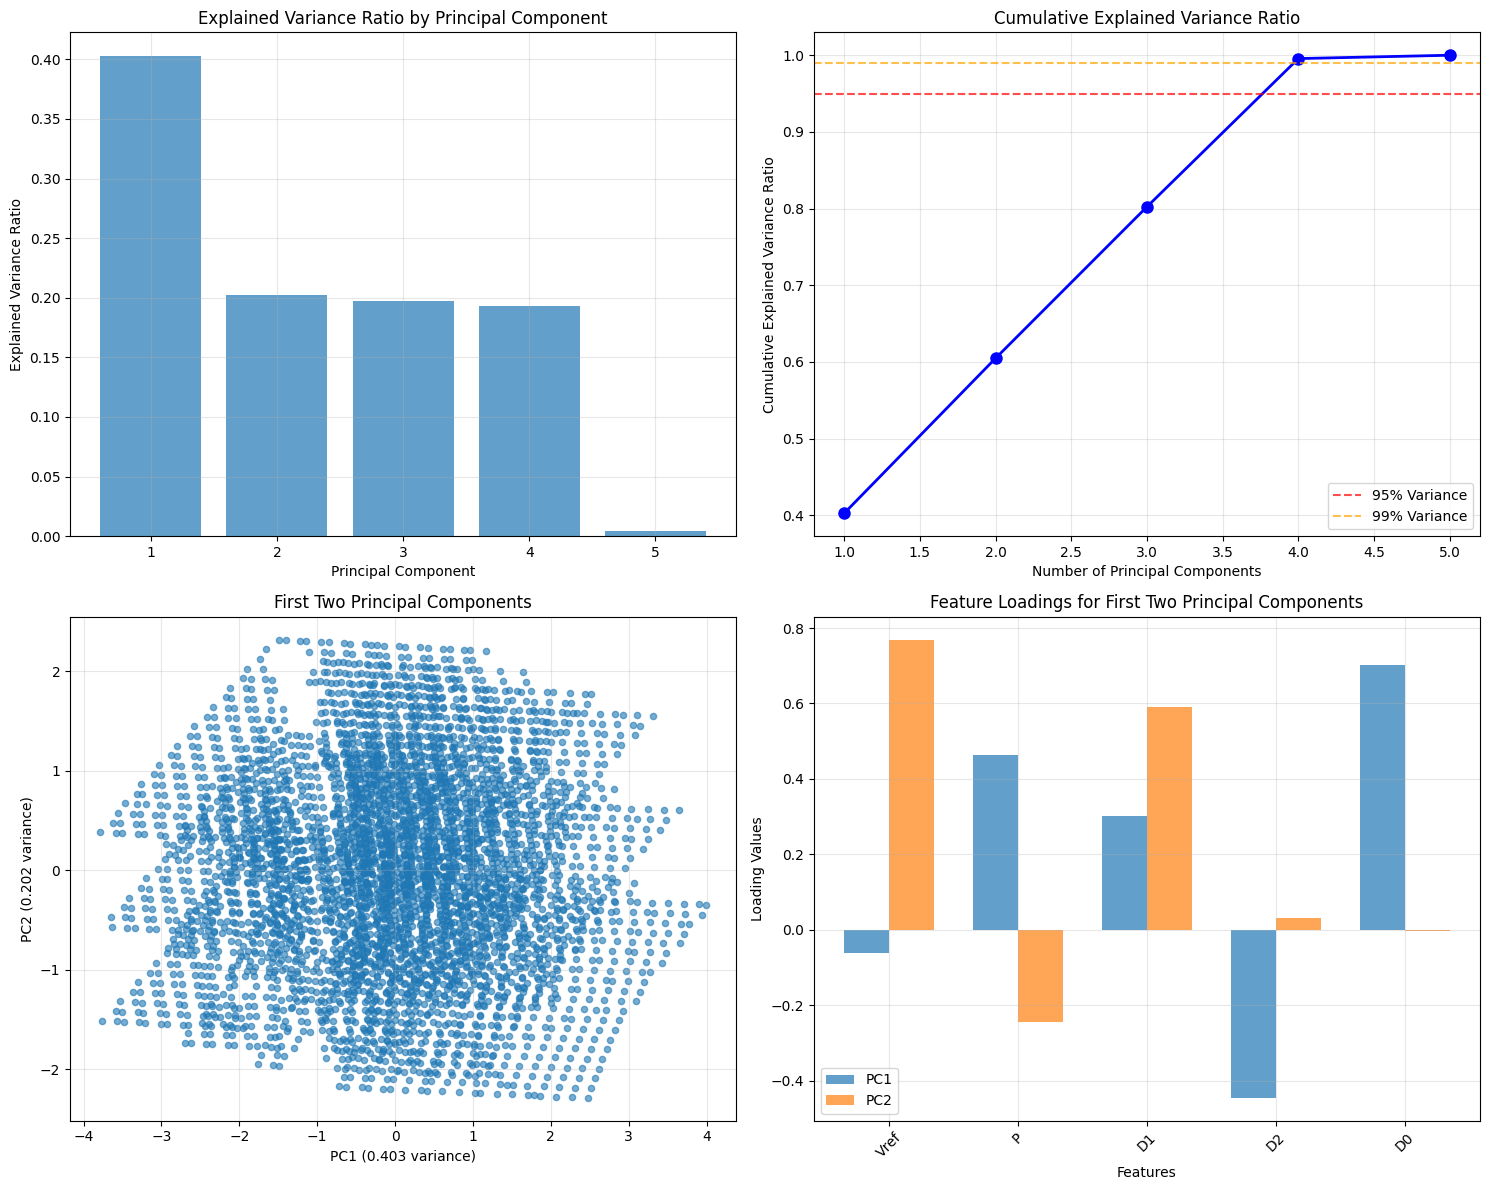

=== PCA ANALYSIS RESULTS ===
Features used: ['Vref', 'P', 'D1', 'D2', 'D0']

Explained variance ratio:
PC1: 0.4025 (40.25%)
PC2: 0.2022 (20.22%)
PC3: 0.1976 (19.76%)
PC4: 0.1933 (19.33%)
PC5: 0.0044 (0.44%)

Cumulative explained variance:
PC1-PC1: 0.4025 (40.25%)
PC1-PC2: 0.6048 (60.48%)
PC1-PC3: 0.8023 (80.23%)
PC1-PC4: 0.9956 (99.56%)
PC1-PC5: 1.0000 (100.00%)

Number of components needed for:
95% variance: 4
99% variance: 4

Feature loadings for PC1:
Vref: -0.0609
P: 0.4644
D1: 0.3015
D2: -0.4455
D0: 0.7009

Feature loadings for PC2:
Vref: 0.7690
P: -0.2454
D1: 0.5895
D2: 0.0316
D0: -0.0040


In [4]:
# @title  {"form-width":"30%"}
# @markdown ### Jargon Explained
# @markdown
# @markdown - **Principal component analysis (PCA):** A statistical method for reducing the dimensionality of a dataset by transforming it into a new, smaller set of uncorrelated variables called *principal components* that capture the maximum possible variance in the original data.
# @markdown   - In this context, PCA is used to double-justify the decision of leaving the outer phase shift `D0` out of the input features.
#------------------------------------------------------------------------------------------------
# Conduct PCA analysis, remember to standardize the features first
#------------------------------------------------------------------------------------------------

# Perform PCA on the selected features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select the features for PCA
pca_features = ["Vref", "P", "D1", "D2", "D0"]
X_pca = df_final[pca_features]

# # Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Perform PCA
pca = PCA()
X_pca_transformed = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Import the function to plot and summarize the PCA results
from utils import plot_and_summarize_pca_results

plot_and_summarize_pca_results(
    explained_variance_ratio,
    cumulative_variance_ratio,
    X_pca_transformed,
    pca,
    pca_features
)


#### 2.3 t-SNE algorithm: Visualize high-dimensional data
* A machine learning algorithm used to visualize high-dimensional data by reducing its dimensions to two or three for easier interpretation and exploration. It reveals complex patterns and clusters in datasets.

Loading precomputed t-SNE embeddings from local drive...
t-SNE features are loaded. Please conduct the next block to visualize the feature domain.
Plotting t-SNE analysis...


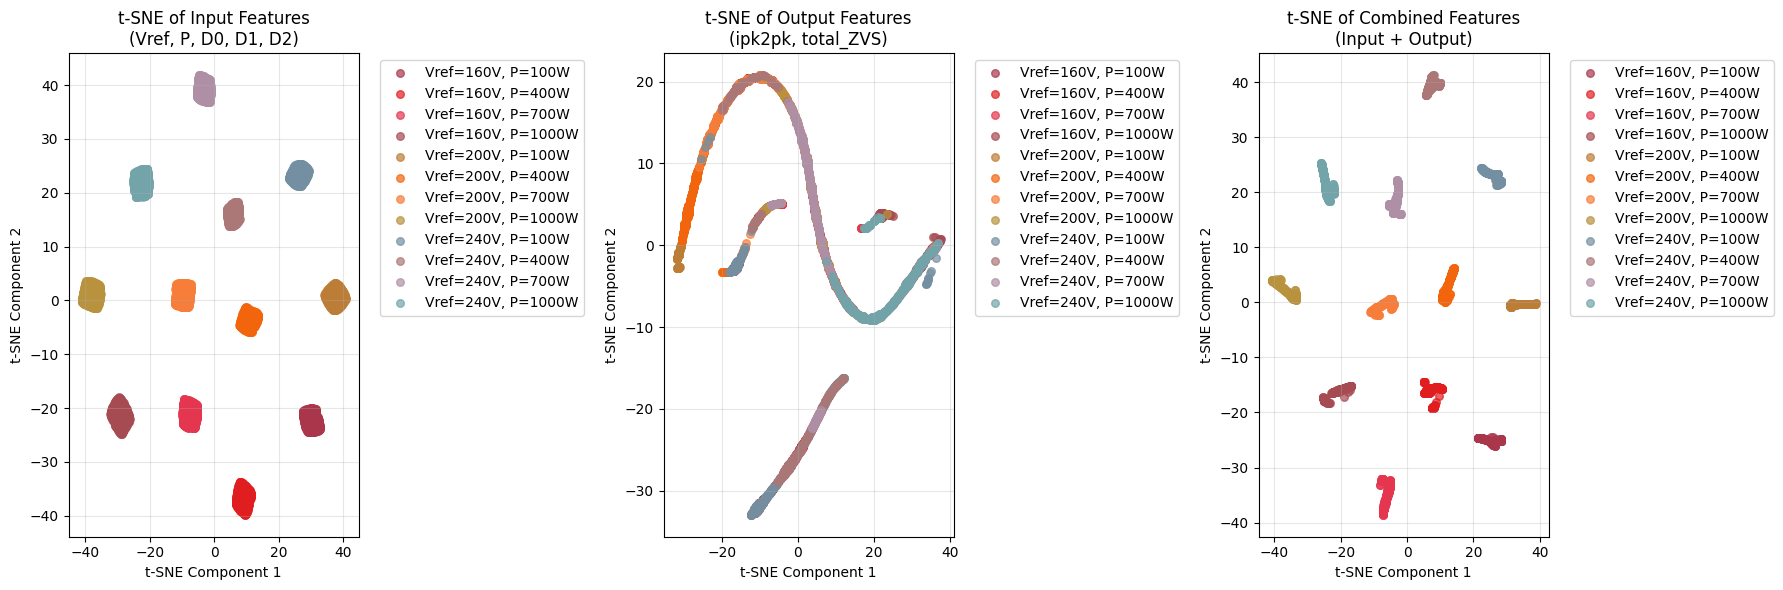


=== t-SNE ANALYSIS SUMMARY ===
Input features: ['Vref', 'P', 'D0', 'D1', 'D2']
Output features: ['ipk2pk', 'total_ZVS']
Combined features: ['Vref', 'P', 'D0', 'D1', 'D2', 'ipk2pk', 'total_ZVS']
Number of samples: 4633
Voltage levels found: [np.int64(160), np.int64(200), np.int64(240)]
Power levels found: [np.int64(100), np.int64(400), np.int64(700), np.int64(1000)]


In [5]:
# @title  {"form-width":"30%"}
#------------------------------------------------------------------------------------------------
# Conduct t-SNE analysis, including 1) input, 2) output, and 3) combined features
#------------------------------------------------------------------------------------------------

# t-SNE Visualization for Input, Output, and Combined Features
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os

# Boolean variable to specify whether to load trained t-SNE models from local drive
load_trained_tsne = True  # Set to True to load from disk, False to train anew

# Prepare data for t-SNE
input_data = df_final[input_features].values
output_data = df_final[output_features].values
combined_data = df_final[input_features + output_features].values

# Get unique voltage levels and power levels for coloring
voltage_levels = df_final['Vref'].unique()
power_levels = df_final['P'].unique()
voltage_colors = plt.cm.Set1(np.linspace(0, 1, len(voltage_levels)))
power_colors = plt.cm.tab10(np.linspace(0, 1, len(power_levels)))
voltage_color_map = dict(zip(voltage_levels, voltage_colors))
power_color_map = dict(zip(power_levels, power_colors))

if load_trained_tsne and os.path.exists("tsne_input_embedding.npy") and os.path.exists("tsne_output_embedding.npy") and os.path.exists("tsne_combined_embedding.npy"):
    print("Loading precomputed t-SNE embeddings from local drive...")
    input_tsne = np.load("tsne_input_embedding.npy")
    output_tsne = np.load("tsne_output_embedding.npy")
    combined_tsne = np.load("tsne_combined_embedding.npy")
    print("t-SNE features are loaded. Please conduct the next block to visualize the feature domain.")
else:
    # 1. t-SNE for Input Features
    print("Computing t-SNE for input features...")
    tsne_input = TSNE(n_components=2, random_state=42, perplexity=200)
    input_tsne = tsne_input.fit_transform(input_data)
    # Save the t-SNE embedding and model
    np.save("tsne_input_embedding.npy", input_tsne)

    # 2. t-SNE for Output Features
    print("Computing t-SNE for output features...")
    tsne_output = TSNE(n_components=2, random_state=42, perplexity=200)
    output_tsne = tsne_output.fit_transform(output_data)
    np.save("tsne_output_embedding.npy", output_tsne)

    # 3. t-SNE for Combined Features
    print("Computing t-SNE for combined features...")
    tsne_combined = TSNE(n_components=2, random_state=42, perplexity=200)
    combined_tsne = tsne_combined.fit_transform(combined_data)
    np.save("tsne_combined_embedding.npy", combined_tsne)


# Visualize t-SNE results
# import the function to plot the t-SNE analysis
from utils import plot_tsne_analysis

# Flag to control whether to plot power levels
# Set to False to only plot voltage levels
# @title  {"form-width":"40%"}
# @markdown ### Jargon Explained
# @markdown
# @markdown - **t-SNE:** A machine learning algorithm used to visualize high-dimensional data by reducing its dimensions to two or three for easier interpretation and exploration.
# @markdown   - It reveals complex patterns and clusters in datasets.
plot_power_levels = True

print("Plotting t-SNE analysis...")
kwargs = {}
if plot_power_levels:
    kwargs = dict(power_levels=power_levels, power_color_map=power_color_map)
plot_tsne_analysis(
    df_final,
    voltage_levels,
    voltage_color_map,
    input_tsne,
    output_tsne,
    combined_tsne,
    input_features,
    output_features,
    **kwargs
)

## Section 3. Data-Driven Modeling of Current Stress and ZVS

#### 3.1 Feedforward NN for Current Stress **Regression**
    Conduct the following experiments one-by-one to understand its effects
* Standardize inputs: Scale inputs within [0, 1]; or normalize to normal distribution with Norm(0, 1)
* Tune some NN hyper-parameters: 1) Hidden size; 2) Number of layers
* Impacts of activation functions on function surface (regression): 1) ReLU; 2) tanh

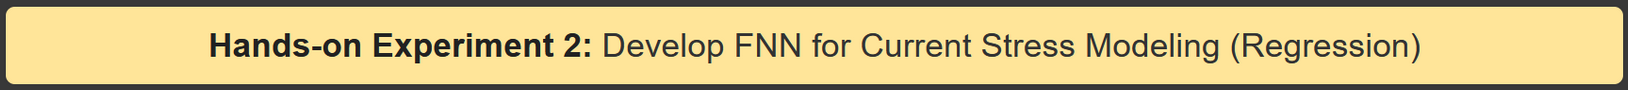

<ul style="background-color:#25e599; padding:10px; border-radius:5px; text-align:left; font-size:1.2em;">
  <b style="color:#222222;">Learning Objectives:</b>
  <li style="color:#333333;">1. Understand the importance of standardization and normalization in power electronics (PE)</li>
  <li style="color:#333333;">2. Recognize good practices for tuning neural network (NN) structures</li>
  <li style="color:#333333;">3. Explore the impact of activation functions on prediction surfaces and contours</li>
</ul>

Training the neural network...


/tmp/ipython-input-1454181044.py:176: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  grad_std = param.grad.std()


Epoch [20/200], LR: 0.100000, Train Loss: 1.034859, Val Loss: 1.089887, Test Loss: 1.088232
Epoch [40/200], LR: 0.050000, Train Loss: 0.525356, Val Loss: 0.649194, Test Loss: 0.709177
Epoch [60/200], LR: 0.050000, Train Loss: 0.462620, Val Loss: 0.409301, Test Loss: 0.418418
Epoch [80/200], LR: 0.025000, Train Loss: 0.436523, Val Loss: 0.456744, Test Loss: 0.439022
Epoch [100/200], LR: 0.025000, Train Loss: 0.343771, Val Loss: 0.318308, Test Loss: 0.316894
Epoch [120/200], LR: 0.012500, Train Loss: 0.301958, Val Loss: 0.338456, Test Loss: 0.311399
Epoch [140/200], LR: 0.012500, Train Loss: 0.286394, Val Loss: 0.292105, Test Loss: 0.286810
Epoch [160/200], LR: 0.006250, Train Loss: 0.306147, Val Loss: 0.287023, Test Loss: 0.286202
Epoch [180/200], LR: 0.006250, Train Loss: 0.334790, Val Loss: 0.282788, Test Loss: 0.276910
Epoch [200/200], LR: 0.003125, Train Loss: 0.274083, Val Loss: 0.278319, Test Loss: 0.275225

=== MODEL PERFORMANCE ===
Mean Squared Error: 0.275776
Root Mean Squared 

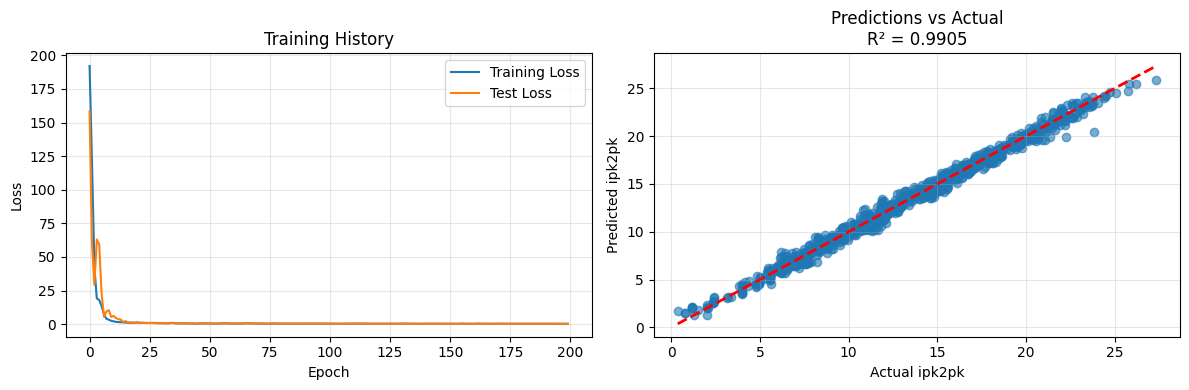

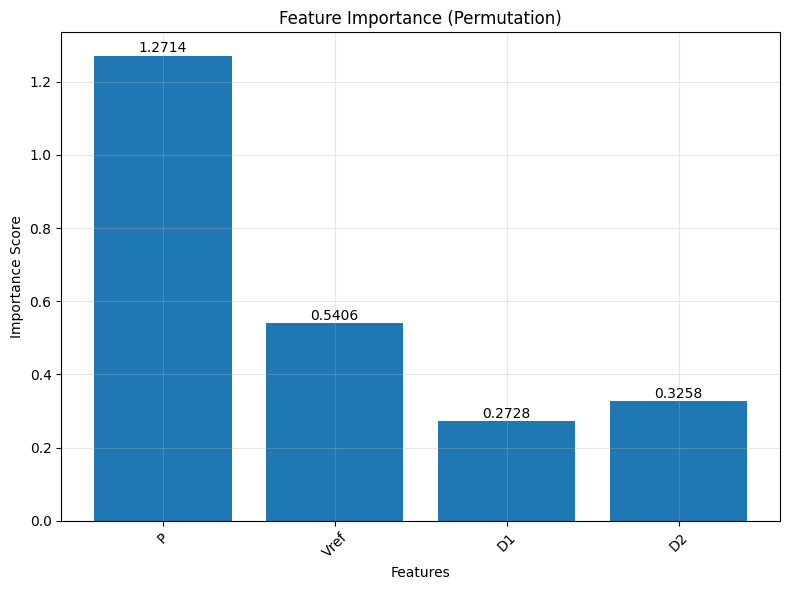


=== FEATURE IMPORTANCE ===
P: 1.271417
Vref: 0.540560
D1: 0.272810
D2: 0.325846


In [7]:
#------------------------------------------------------------------------------------------------
# Define the neural network architecture, implement the training process, and tune the hyper-parameters
# TODO: Hands-on Experiment 2 - Develop FNN for Current Stress Modeling
#------------------------------------------------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import copy

# =========================
# Configurable flags/params
# =========================
# @title  {"form-width":"40%"}
# Flag: whether to standardize input features
USE_STANDARDIZE = True # @param ["False","True"] {"type":"raw"}
# Parameter: hidden layer size
HIDDEN_SIZE = 32 # @param {"type":"slider","min":4,"max":128,"step":4}
# Parameter: number of hidden layers
NUM_HIDDEN_LAYERS = 1 # @param {"type":"slider","min":1,"max":3,"step":1}
# Variable: activation function, options: "relu", "tanh"
ACTIVATION = "relu" # @param ["relu","tanh"]
# @markdown ### Comments
# @markdown
# @markdown  - **Standardization/Normalization:** Crucial for PE datasets since features usually have diverse ranges and magnitudes (e.g., `fs` in kilo-Hertz, `P` in kilo-Watt, `L` in micro-Henry).
# @markdown  - **Train/Validation/Test Data Partition:**
# @markdown    - **Training set:** Used for model learning
# @markdown    - **Validation set:** Used for tuning hyperparameters and early stopping to avoid overfitting
# @markdown    - **Test set:** Used *only* to evaluate generalization capability (never used during training or hyperparameter tuning)
# @markdown  - **Good Practice for Tuning Neural Network Structure:**
# @markdown    1. Adjust `num_hidden_layers` from a small value while keeping `hidden_size` fixed
# @markdown    2. After determining `num_hidden_layers`, adjust `hidden_size`
# @markdown    3. Tune other hyperparameters such as the regularization factor
# @markdown
# @markdown  ### Jargon Explained
# @markdown
# @markdown  - **ReLU activation function:** Rectified Linear Unit, a piecewise linear function
# @markdown  - **tanh activation function:** Hyperbolic tangent function, smooth and bounded within `(-1, 1)`


# Flag: whether to use batch normalization
USE_BATCHNORM = True
# Flag: whether to z-score gradients
USE_ZSCORE_GRAD = True
# Flag: whether to use learning rate scheduler
USE_LR_SCHEDULER = True

# =========================
# Activation function selector
# =========================
def get_activation(name):
    if name == "relu":
        return nn.ReLU()
    elif name == "tanh":
        return nn.Tanh()
    else:
        raise ValueError(f"Unknown activation: {name}")

# =========================
# Neural network definition
# =========================
class CurrentStressMLP(nn.Module):
    def __init__(self, input_size=4, hidden_size=32, num_hidden_layers=2, activation="relu", use_batchnorm=True):
        super(CurrentStressMLP, self).__init__()
        layers = []
        in_dim = input_size
        act = get_activation(activation)
        for i in range(num_hidden_layers):
            layers.append(nn.Linear(in_dim, hidden_size))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(act)
            in_dim = hidden_size
        layers.append(nn.Linear(hidden_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# =========================
# Custom dataset class
# =========================
class CurrentStressDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# =========================
# Prepare the data
# =========================
input_features = ["P", "Vref", "D1", "D2"]
output_feature = "ipk2pk"

# Extract features and target
X = df_final[input_features].values
y = df_final[output_feature].values

# Split the data: train/val/test (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Feature scaling or normalization is important for the training of the neural network
if USE_STANDARDIZE:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
else:
    X_train_scaled = X_train
    X_val_scaled = X_val
    X_test_scaled = X_test

# Create datasets and dataloaders
train_dataset = CurrentStressDataset(X_train_scaled, y_train)
val_dataset = CurrentStressDataset(X_val_scaled, y_val)
test_dataset = CurrentStressDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# =========================
# Initialize the model
# =========================
model_NN_regression = CurrentStressMLP(
    input_size=len(input_features),
    hidden_size=HIDDEN_SIZE,
    num_hidden_layers=NUM_HIDDEN_LAYERS,
    activation=ACTIVATION,
    use_batchnorm=USE_BATCHNORM
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_NN_regression.parameters(), lr=0.1)  # Higher initial learning rate

if USE_LR_SCHEDULER:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)  # Reduce LR every 200 epochs

# =========================
# Training loop
# =========================
num_epochs = 200
train_losses = []
val_losses = []
test_losses = []  # <--- Add test loss tracking
best_val_loss = float('inf')
best_model_state = None

print("Training the neural network...")
for epoch in range(num_epochs):
    # Training phase
    model_NN_regression.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_NN_regression(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()

        # Gradient z-scoring if enabled
        if USE_ZSCORE_GRAD:
            for param in model_NN_regression.parameters():
                if param.grad is not None:
                    grad_mean = param.grad.mean()
                    grad_std = param.grad.std()
                    if grad_std > 0:
                        param.grad = (param.grad - grad_mean) / grad_std

        optimizer.step()
        train_loss += loss.item()

    # Update learning rate if enabled
    if USE_LR_SCHEDULER:
        scheduler.step()

    # Validation phase
    model_NN_regression.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model_NN_regression(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    # Test phase (record test loss)
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model_NN_regression(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    test_losses.append(test_loss / len(test_loader))

    # Save best model on validation set
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_model_state = copy.deepcopy(model_NN_regression.state_dict())

    if (epoch + 1) % 20 == 0:
        if USE_LR_SCHEDULER:
            current_lr = scheduler.get_last_lr()[0]
        else:
            current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{num_epochs}], LR: {current_lr:.6f}, Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}, Test Loss: {test_losses[-1]:.6f}')

# Load best model weights (on validation set)
if best_model_state is not None:
    model_NN_regression.load_state_dict(best_model_state)


#------------------------------------------------------------------------------------------------
# Plot and report the model performance
#------------------------------------------------------------------------------------------------

# Evaluate the model
model_NN_regression.eval()
with torch.no_grad():
    y_pred = model_NN_regression(torch.FloatTensor(X_test_scaled)).numpy().flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

from utils import plot_and_report_model_performance

# Plot and report the model performance
plot_and_report_model_performance(
    mse, rmse, r2,
    train_losses, test_losses,
    y_test, y_pred,
    model_NN_regression, X_test_scaled, input_features
)


=== 3D MESH PLOT ===
Generating 3D mesh plot of current stress vs D1 and D2 (P=100, Vref=240)...


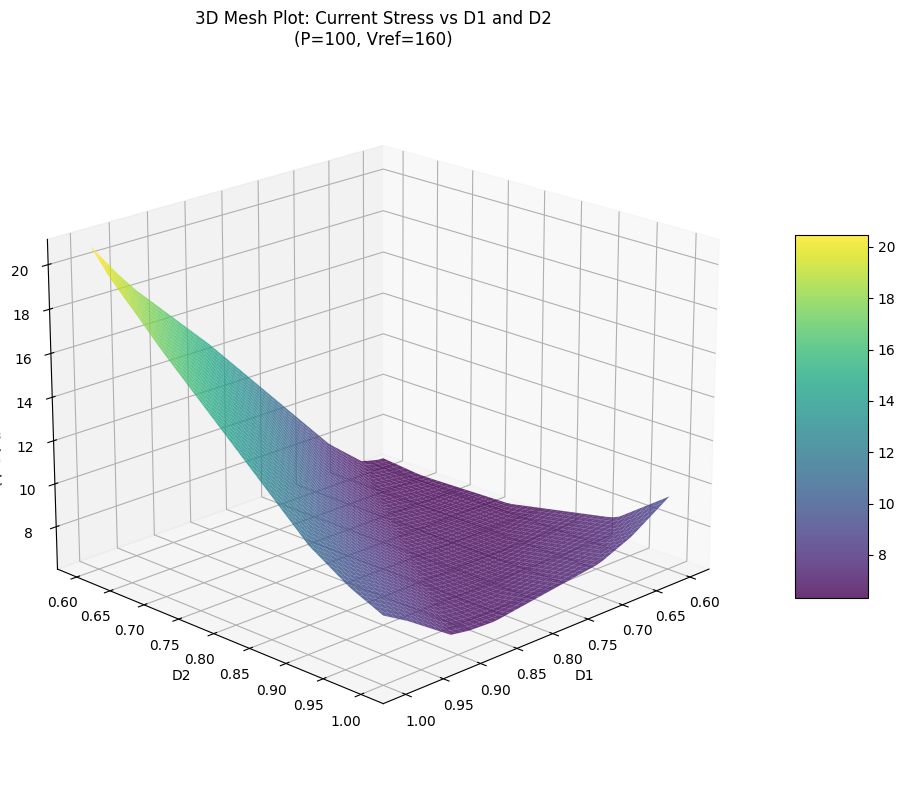

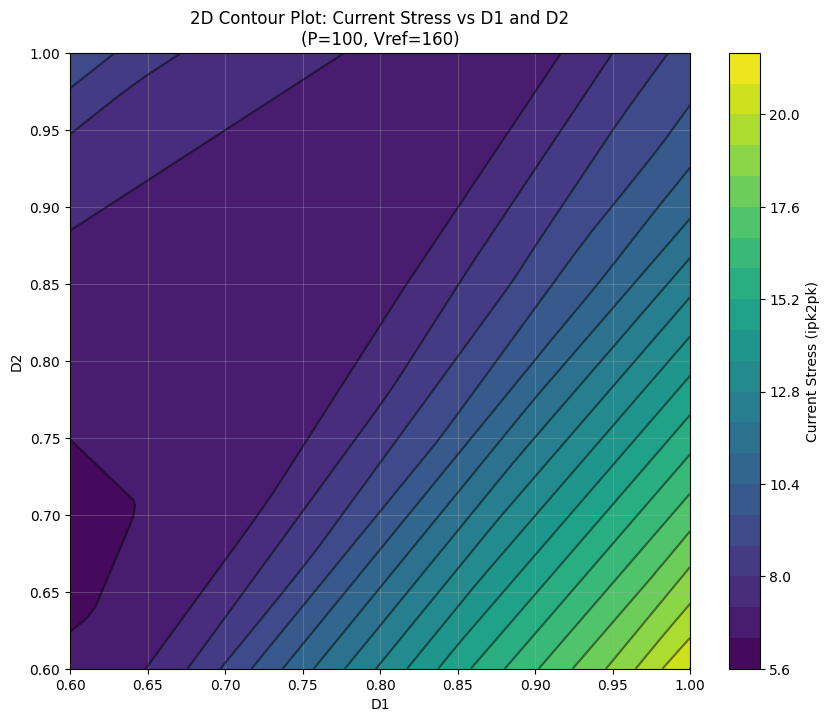

In [8]:
# @title  {"form-width":"30%"}
# @markdown ### Comments
# @markdown
# @markdown - **Observe the impacts of activation function** on predicted surface and contours.
#------------------------------------------------------------------------------------------------
# Observe the model surface and contour plots, change the activation function and understand the effects
#------------------------------------------------------------------------------------------------

# 3D Mesh plot of current stress with respect to D1 and D2
print(f"\n=== 3D MESH PLOT ===")
print("Generating 3D mesh plot of current stress vs D1 and D2 (P=100, Vref=240)...")

# Create meshgrid for D1 and D2
D1_range = np.linspace(X_test_scaled[:, 2].min(), X_test_scaled[:, 2].max(), 50)  # D1 is at index 2
D2_range = np.linspace(X_test_scaled[:, 3].min(), X_test_scaled[:, 3].max(), 50)  # D2 is at index 3
D1_mesh, D2_mesh = np.meshgrid(D1_range, D2_range)

# Fixed values for P and Vref (scaled)
P_fixed = 100
Vref_fixed = 160

# Transform the fixed values using the same scaler
P_scaled = scaler.transform([[P_fixed, 0, 0, 0]])[0, 0]  # Get P value
Vref_scaled = scaler.transform([[0, Vref_fixed, 0, 0]])[0, 1]  # Get Vref value

# Create a 3D mesh plot of the current stress vs D1 and D2
# Create input array for prediction
X_contour = np.zeros((D1_mesh.size, 4))
X_contour[:, 0] = P_scaled  # P (fixed) - index 0
X_contour[:, 1] = Vref_scaled  # Vref (fixed) - index 1
X_contour[:, 2] = D1_mesh.flatten()  # D1 - index 2
X_contour[:, 3] = D2_mesh.flatten()  # D2 - index 3

# Predict current stress
model_NN_regression.eval()
with torch.no_grad():
    stress_pred = model_NN_regression(torch.FloatTensor(X_contour)).numpy().flatten()

# Reshape predictions back to meshgrid shape
stress_mesh = stress_pred.reshape(D1_mesh.shape)

# Inverse transform D1 and D2 back to original scale
D1_original = np.zeros((D1_mesh.size, 4))
D1_original[:, 2] = D1_mesh.flatten()  # Set D1 values
D1_original = scaler.inverse_transform(D1_original)
D1_original = D1_original[:, 2].reshape(D1_mesh.shape)


D2_original = np.zeros((D2_mesh.size, 4))
D2_original[:, 3] = D2_mesh.flatten()  # Set D2 values
D2_original = scaler.inverse_transform(D2_original)
D2_original = D2_original[:, 3].reshape(D2_mesh.shape)

# Plot the 3D mesh and 2D contour plot of the current stress
from utils import plot_stress_mesh_and_contour

plot_stress_mesh_and_contour(D1_original, D2_original, stress_mesh,
                                 mesh_title=f'3D Mesh Plot: Current Stress vs D1 and D2\n(P={P_fixed}, Vref={Vref_fixed})',
                                 contour_title=f'2D Contour Plot: Current Stress vs D1 and D2\n(P={P_fixed}, Vref={Vref_fixed})')

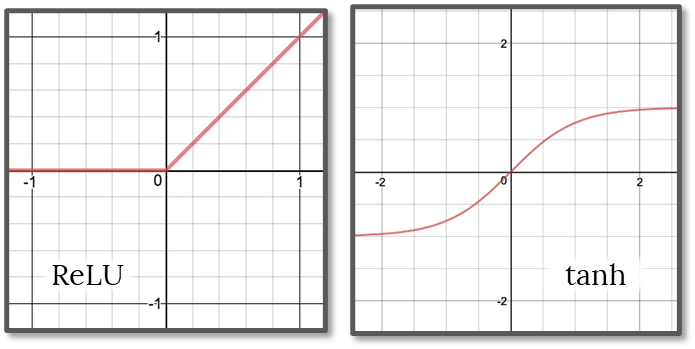

#### 3.2 Feedforward NN for Zero Voltage Switching **Classification**
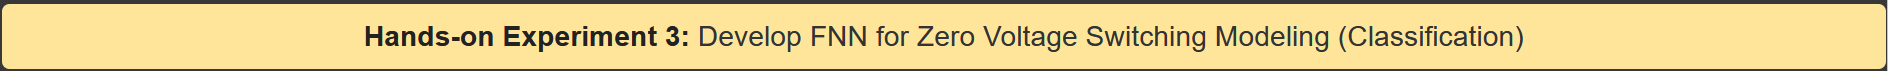

<ul style="background-color:#25e599; padding:10px; border-radius:5px; text-align:left; font-size:1.2em;">
  <b style="color:#222222;">Learning Objectives:</b>
  <li style="color:#333333;">1. Adjust model head (output layer and loss function) to shift to ZVS classification</li>
  <li style="color:#333333;">  -- ipk2pk regression: Linear layer + Mean-squared error </li>
  <li style="color:#333333;">  -- ZVS classification: Linear layer + Cross-entropy loss </li>
</ul>

Training the ZVS classification neural network...
Epoch [20/300], LR: 0.100000, Train Loss: 0.116916, Val Loss: 0.157299, Test Loss: 0.200007
Epoch [40/300], LR: 0.050000, Train Loss: 0.095802, Val Loss: 0.127683, Test Loss: 0.159582
Epoch [60/300], LR: 0.050000, Train Loss: 0.082508, Val Loss: 0.143120, Test Loss: 0.133345
Epoch [80/300], LR: 0.025000, Train Loss: 0.095656, Val Loss: 0.116839, Test Loss: 0.126979
Epoch [100/300], LR: 0.025000, Train Loss: 0.054086, Val Loss: 0.090388, Test Loss: 0.102539
Epoch [120/300], LR: 0.012500, Train Loss: 0.053497, Val Loss: 0.101950, Test Loss: 0.106638
Epoch [140/300], LR: 0.012500, Train Loss: 0.075985, Val Loss: 0.083094, Test Loss: 0.105837
Epoch [160/300], LR: 0.006250, Train Loss: 0.058235, Val Loss: 0.084841, Test Loss: 0.103142
Epoch [180/300], LR: 0.006250, Train Loss: 0.046844, Val Loss: 0.085670, Test Loss: 0.104521
Epoch [200/300], LR: 0.003125, Train Loss: 0.053101, Val Loss: 0.088000, Test Loss: 0.108567
Epoch [220/300], LR: 0.0

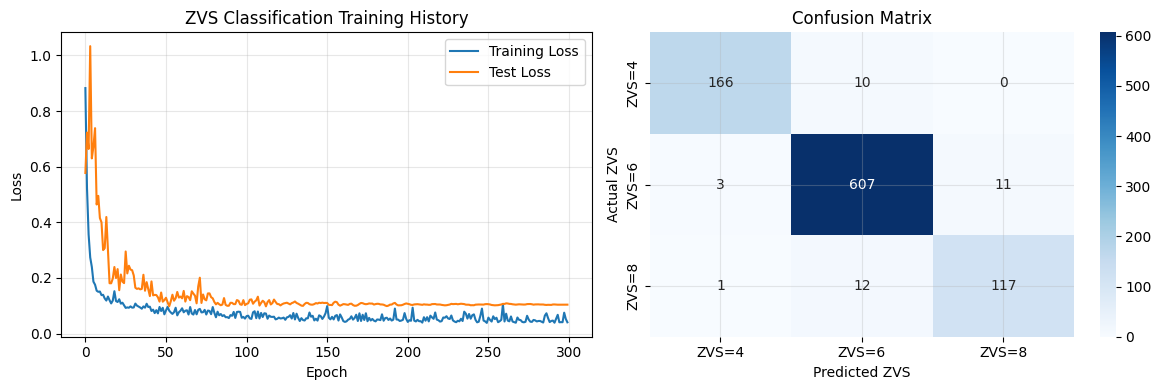

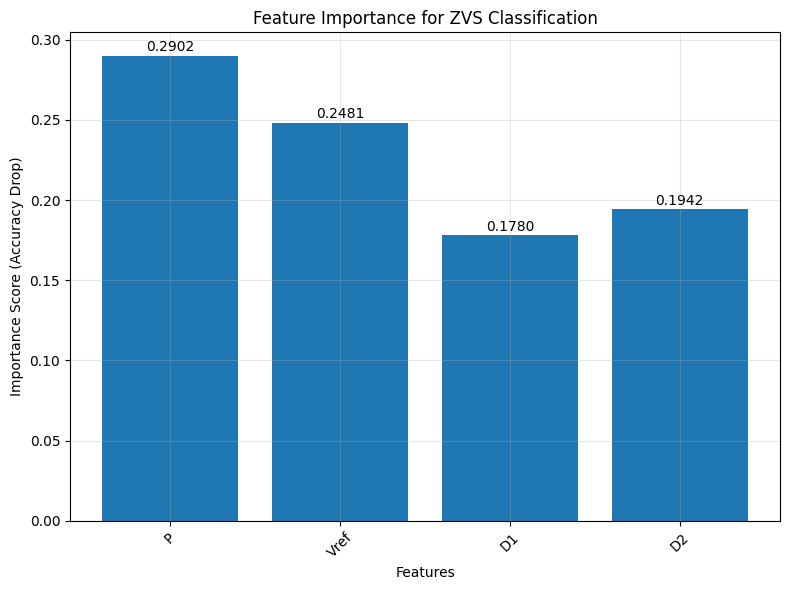


=== FEATURE IMPORTANCE FOR ZVS CLASSIFICATION ===
P: 0.290183
Vref: 0.248112
D1: 0.177994
D2: 0.194175

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       ZVS=4       0.98      0.94      0.96       176
       ZVS=6       0.97      0.98      0.97       621
       ZVS=8       0.91      0.90      0.91       130

    accuracy                           0.96       927
   macro avg       0.95      0.94      0.95       927
weighted avg       0.96      0.96      0.96       927



In [9]:
#------------------------------------------------------------------------------------------------
# Define the neural network architecture, implement the training process, and tune the hyper-parameters
# TODO: Hands-on Experiment 3 - Develop FNN for Zero Voltage Switching Modeling (Classification)
#------------------------------------------------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import copy

# =========================
# Configurable flags/params
# =========================
# @title  {"form-width":"40%"}
# Flag: whether to standardize input features
USE_STANDARDIZE = True # @param ["False","True"] {"type":"raw"}
# Flag: whether to use batch normalization
USE_BATCHNORM = True
# Flag: whether to z-score gradients
USE_ZSCORE_GRAD = True
# Flag: whether to use learning rate scheduler
USE_LR_SCHEDULER = True

# Parameter: hidden layer size
HIDDEN_SIZE = 32 # @param {"type":"slider","min":4,"max":128,"step":4}
# Parameter: number of hidden layers
NUM_HIDDEN_LAYERS = 2 # @param {"type":"slider","min":1,"max":3,"step":1}

# Variable: activation function, options: "relu", "tanh"
ACTIVATION = "relu" # @param ["relu","tanh"]
# @markdown ### Jargon Explained
# @markdown
# @markdown - **Confusion Matrix:** A table used to evaluate the performance of a classification model by comparing predicted labels with true labels.
# @markdown
# @markdown - **F1 Score:** A metric that balances precision and recall, especially useful for imbalanced datasets.
# @markdown   - A higher F1 score indicates a better balance between precision and recall.

# =========================
# Activation function selector
# =========================
def get_activation(name):
    if name == "relu":
        return nn.ReLU()
    elif name == "tanh":
        return nn.Tanh()
    else:
        raise ValueError(f"Unknown activation: {name}")

# =========================
# Neural network definition for ZVS classification
# =========================
class ZVSClassificationMLP(nn.Module):
    def __init__(self, input_size=4, hidden_size=32, num_hidden_layers=2, activation="relu", use_batchnorm=True, num_classes=3):
        super(ZVSClassificationMLP, self).__init__()
        layers = []
        in_dim = input_size
        act = get_activation(activation)
        for i in range(num_hidden_layers):
            layers.append(nn.Linear(in_dim, hidden_size))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(act)
            in_dim = hidden_size
        layers.append(nn.Linear(hidden_size, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# =========================
# Custom dataset class for ZVS classification
# =========================
class ZVSClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        # Map 4->0, 6->1, 8->2 for 3 classes (0,1,2)
        self.map_y = {4: 0, 6: 1, 8: 2}

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        y_value = self.y[idx].item()
        return self.X[idx], self.map_y[y_value]

# =========================
# Prepare the data
# =========================
input_features = ["P", "Vref", "D1", "D2"]
output_feature = "total_ZVS"

# Extract features and target
X = df_final[input_features].values
y = df_final[output_feature].values

# Split the data: train/val/test (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Feature scaling or normalization is important for the training of the neural network
if USE_STANDARDIZE:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
else:
    X_train_scaled = X_train
    X_val_scaled = X_val
    X_test_scaled = X_test

# Create datasets and dataloaders
train_dataset = ZVSClassificationDataset(X_train_scaled, y_train)
val_dataset = ZVSClassificationDataset(X_val_scaled, y_val)
test_dataset = ZVSClassificationDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# =========================
# Initialize the model
# =========================
num_classes = len(np.unique([4, 6, 8]))  # Always 3 for this problem
model_NN_classification = ZVSClassificationMLP(
    input_size=len(input_features),
    hidden_size=HIDDEN_SIZE,
    num_hidden_layers=NUM_HIDDEN_LAYERS,
    activation=ACTIVATION,
    use_batchnorm=USE_BATCHNORM,
    num_classes=num_classes
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_NN_classification.parameters(), lr=0.1)  # Higher initial learning rate

if USE_LR_SCHEDULER:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)  # Reduce LR every 200 epochs

# =========================
# Training loop
# =========================
num_epochs = 300
train_losses = []
val_losses = []
test_losses = []
best_val_loss = float('inf')
best_model_state = None

print("Training the ZVS classification neural network...")
for epoch in range(num_epochs):
    # Training phase
    model_NN_classification.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_NN_classification(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()

        # Gradient z-scoring if enabled
        if USE_ZSCORE_GRAD:
            for param in model_NN_classification.parameters():
                if param.grad is not None:
                    grad_mean = param.grad.mean()
                    grad_std = param.grad.std()
                    if grad_std > 0:
                        param.grad = (param.grad - grad_mean) / grad_std

        optimizer.step()
        train_loss += loss.item()

    # Update learning rate if enabled
    if USE_LR_SCHEDULER:
        scheduler.step()

    # Validation phase
    model_NN_classification.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model_NN_classification(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    # Test phase (track test loss)
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model_NN_classification(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    test_losses.append(test_loss / len(test_loader))

    # Save best model on validation set
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_model_state = copy.deepcopy(model_NN_classification.state_dict())

    if (epoch + 1) % 20 == 0:
        if USE_LR_SCHEDULER:
            current_lr = scheduler.get_last_lr()[0]
        else:
            current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{num_epochs}], LR: {current_lr:.6f}, Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}, Test Loss: {test_losses[-1]:.6f}')

# Load best model weights (on validation set)
if best_model_state is not None:
    model_NN_classification.load_state_dict(best_model_state)


#------------------------------------------------------------------------------------------------
# Plot and report the ZVS classification model performance
#------------------------------------------------------------------------------------------------

# Import required metrics from sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Evaluate the ZVS classification model
model_NN_classification.eval()
with torch.no_grad():
    y_pred_probs = model_NN_classification(torch.FloatTensor(X_test_scaled))
    y_pred_classes = torch.argmax(y_pred_probs, dim=1).numpy()

# Apply the same mapping to y_test as used in the dataset
map_y = {4: 0, 6: 1, 8: 2}  # Map 4->0, 6->1, 8->2 for 3 classes (0,1,2)
y_test_mapped = np.array([map_y[y] for y in y_test])

# Calculate classification metrics
accuracy = accuracy_score(y_test_mapped, y_pred_classes)
precision = precision_score(y_test_mapped, y_pred_classes, average='weighted')
recall = recall_score(y_test_mapped, y_pred_classes, average='weighted')
f1 = f1_score(y_test_mapped, y_pred_classes, average='weighted')

print(f"\n=== ZVS CLASSIFICATION MODEL PERFORMANCE ===")
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-Score: {f1:.6f}")

# Plot the classification results
from utils import plot_classification_results

plot_classification_results(
    train_losses,
    test_losses,
    y_test_mapped,
    y_pred_classes,
    model_NN_classification,
    X_test_scaled,
    input_features
)


=== 2D ZVS CLASSIFICATION PLOT ===
Generating 2D plot of ZVS classification vs D1 and D2 (P=300, Vref=160)...


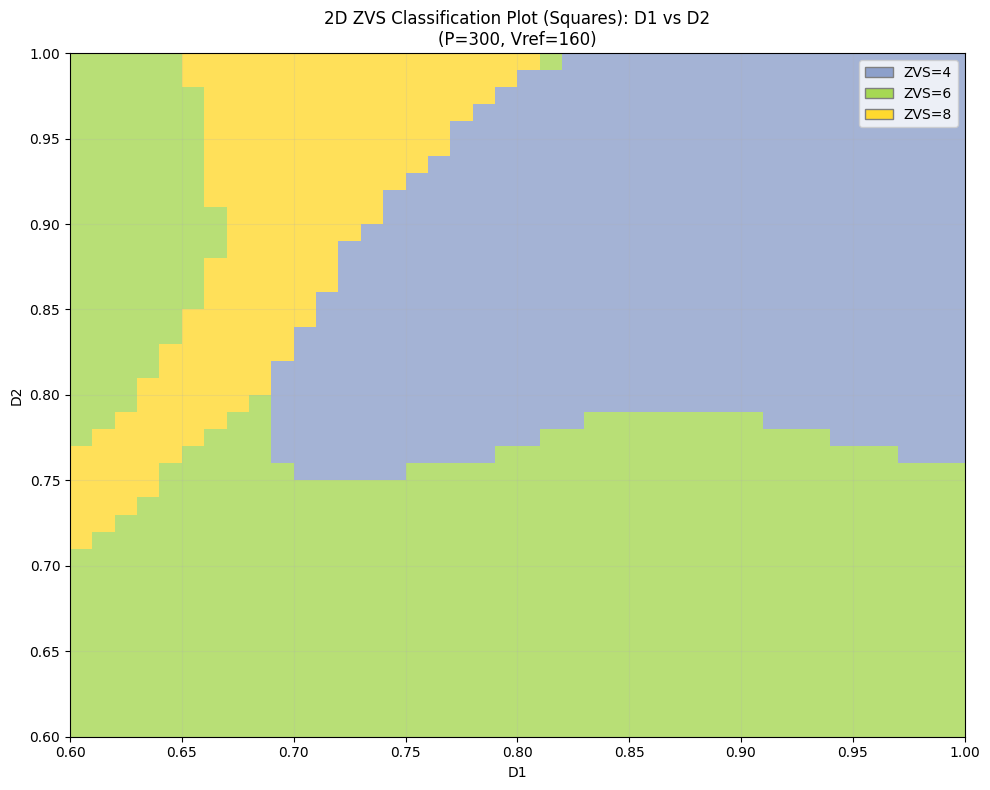

In [10]:
#------------------------------------------------------------------------------------------------
# Observe the decision plane, change the activation function and understand the effects
#------------------------------------------------------------------------------------------------

# Create a 2D plot of ZVS classification with respect to the meshgrid of D1 and D2
# Create meshgrid for D1 and D2
D1_range = np.linspace(X_test_scaled[:, 2].min(), X_test_scaled[:, 2].max(), 500)  # D1 is at index 2
D2_range = np.linspace(X_test_scaled[:, 3].min(), X_test_scaled[:, 3].max(), 500)  # D2 is at index 3
D1_mesh, D2_mesh = np.meshgrid(D1_range, D2_range)

# Fixed values for P and Vref (scaled)
P_fixed = 300
Vref_fixed = 160

print(f"\n=== 2D ZVS CLASSIFICATION PLOT ===")
print(f"Generating 2D plot of ZVS classification vs D1 and D2 (P={P_fixed}, Vref={Vref_fixed})...")

# Transform the fixed values using the same scaler
P_scaled = scaler.transform([[P_fixed, 0, 0, 0]])[0, 0]  # Get P value
Vref_scaled = scaler.transform([[0, Vref_fixed, 0, 0]])[0, 1]  # Get Vref value

# Create input array for prediction
X_contour = np.zeros((D1_mesh.size, 4))
X_contour[:, 0] = P_scaled  # P (fixed) - index 0
X_contour[:, 1] = Vref_scaled  # Vref (fixed) - index 1
X_contour[:, 2] = D1_mesh.flatten()  # D1 - index 2
X_contour[:, 3] = D2_mesh.flatten()  # D2 - index 3

# Predict ZVS classification
model_NN_classification.eval()
with torch.no_grad():
    zvs_pred = torch.argmax(model_NN_classification(torch.FloatTensor(X_contour)), dim=1).numpy()

# Reshape predictions back to meshgrid shape
zvs_mesh = zvs_pred.reshape(D1_mesh.shape)

# Inverse transform D1 and D2 back to original scale
D1_original = np.zeros((D1_mesh.size, 4))
D1_original[:, 2] = D1_mesh.flatten()  # Set D1 values
D1_original = scaler.inverse_transform(D1_original)
D1_original = D1_original[:, 2].reshape(D1_mesh.shape)

D2_original = np.zeros((D2_mesh.size, 4))
D2_original[:, 3] = D2_mesh.flatten()  # Set D2 values
D2_original = scaler.inverse_transform(D2_original)
D2_original = D2_original[:, 3].reshape(D2_mesh.shape)

# Plot the 2D ZVS classification plot
from utils import plot_2d_zvs_classification

# plot the 2D ZVS classification plot
plot_2d_zvs_classification(D1_original, D2_original, zvs_mesh, P_fixed, Vref_fixed)

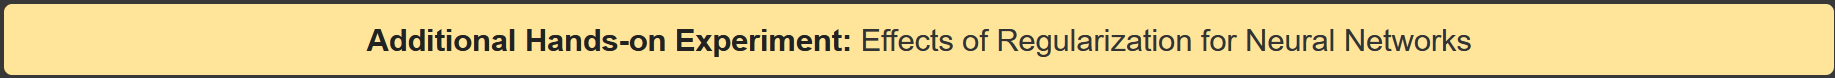

<ul style="background-color:#25e599; padding:10px; border-radius:5px; text-align:left; font-size:1.2em;">
  <b style="color:#222222;">Learning Objectives:</b>
  <li style="color:#333333;">1. Impact of L1 regularization on neural weights </li>
  <li style="color:#333333;">2. Impact of L2 regularization on neural weights </li>
</ul>

<a href="https://playground.tensorflow.org/" target="_blank" style="font-size:1.15em; color:#1595c0; font-weight:bold; text-decoration:none;">
  &#9654; Neural Network Playground by Tensorflow
</a>

#### 3.3 **Anytime** Algorithms: Ensemble Learning Algorithms - Random Forest and XGBoost
    Implement XGBoost algorithms to model current stress and ZVS performances

In [ ]:
#------------------------------------------------------------------------------------------------
# Define the xgboost model for current stress modeling, and implement the training process
#------------------------------------------------------------------------------------------------

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
input_features = ["P", "Vref", "D1", "D2"]
output_feature = "ipk2pk"

# Extract features and target
X = df_final[input_features].values
y = df_final[output_feature].values

# Split the data: train/val/test (60/20/20) similar to the reference codes
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
    eval_metric='rmse'
)

# Training the XGBoost model
print("Training the XGBoost model...")
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=True
)

# Make predictions
y_train_pred = xgb_model.predict(X_train_scaled)
y_val_pred = xgb_model.predict(X_val_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nXGBoost Results:")
print(f"Train MSE: {train_mse:.6f}")
print(f"Val MSE: {val_mse:.6f}")
print(f"Test MSE: {test_mse:.6f}")
print(f"Train R²: {train_r2:.6f}")
print(f"Val R²: {val_r2:.6f}")
print(f"Test R²: {test_r2:.6f}")

# Feature importance
feature_importance = xgb_model.feature_importances_
feature_names = input_features

# Plot the feature importance and predictions
from utils import plot_xgboost_feature_importance_and_predictions

plot_xgboost_feature_importance_and_predictions(
    feature_names=feature_names,
    feature_importance=feature_importance,
    y_train=y_train,
    y_train_pred=y_train_pred,
    train_r2=train_r2,
    y_test=y_test,
    y_test_pred=y_test_pred,
    test_r2=test_r2
)


In [ ]:
#------------------------------------------------------------------------------------------------
# Define the xgboost model for ZVS classification, and implement the training process
#------------------------------------------------------------------------------------------------

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for ZVS classification
input_features = ["P", "Vref", "D1", "D2"]
output_feature = "total_ZVS"

# Extract features and target
X = df_final[input_features].values
y = df_final[output_feature].values

# Create mapping for ZVS classes
map_y = {4: 0, 6: 1, 8: 2}  # Map 4->0, 6->1, 8->2 for 3 classes (0,1,2)
y_mapped = np.array([map_y[y_val] for y_val in y])

# Split the data: train/val/test (60/20/20) similar to the regression code above
X_temp, X_test, y_temp, y_test = train_test_split(X, y_mapped, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Initialize and train XGBoost classifier with optimized hyperparameters for class imbalance
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100,          # Number of boosting rounds
    max_depth=6,                # Maximum depth of trees
    learning_rate=0.2,        # Learning rate (eta)
    random_state=42,
    eval_metric='merror',        # Multiclass classification error rate
    early_stopping_rounds=5,     # Early stopping to prevent overfitting
)

print("Training the ZVS classification XGBoost model...")
xgb_classifier.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=True
)

# Make predictions
y_train_pred = xgb_classifier.predict(X_train_scaled)
y_val_pred = xgb_classifier.predict(X_val_scaled)
y_test_pred = xgb_classifier.predict(X_test_scaled)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n=== XGBOOST ZVS CLASSIFICATION RESULTS ===")
print(f"Training Accuracy: {train_accuracy:.6f}")
print(f"Validation Accuracy: {val_accuracy:.6f}")
print(f"Test Accuracy: {test_accuracy:.6f}")

# Plot the classification results
from utils import classification_analysis

classification_analysis(
    y_train, y_train_pred, train_accuracy,
    y_test, y_test_pred, test_accuracy,
    xgb_classifier, input_features,
    y_mapped
)


## Section 4. Modulation Optimization with Meta-Heuristic Algorithms
* Particle swarm optimization to search within D1 and D2 ranges given P and Vref values

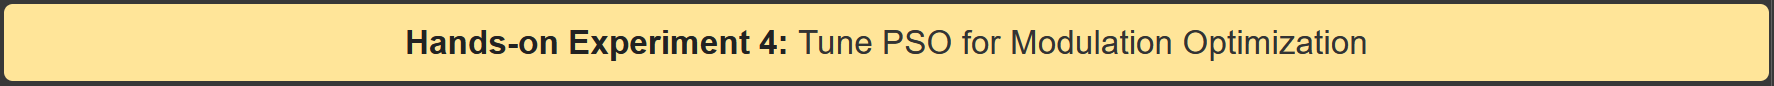
<ul style="background-color:#25e599; padding:10px; border-radius:5px; text-align:left; font-size:1.2em;">
  <b style="color:#222222;">Learning Objectives:</b>
  <li style="color:#333333;">1. Integrate trained data-driven models into MHA framework </li>
  <li style="color:#333333;">2. Tune hyperparameters of MHAs to balance global exploration and local exploitation </li>
</ul>

In [11]:
#------------------------------------------------------------------------------------------------
# Implement the PSO algorithm to search within D1 and D2 ranges given P and Vref values
# TODO: Hands-on Experiment 4 - Tune PSO for Modulation Optimization
#------------------------------------------------------------------------------------------------

import pyswarms as ps
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Set fixed parameters
P_fixed = 100
Vref_fixed = 160

# Parameterize w_start, w_end, and velocity bounds as percentage of search range
# @title  {"form-width":"40%"}
# Parameter: Initial value of inertia weight
w_start = 0.9 # @param {"type":"slider","min":0.01,"max":0.99,"step":0.01}
# Parameter: Final value of inertia weight
w_end = 0.4 # @param {"type":"slider","min":0.01,"max":0.99,"step":0.01}
# Set velocity clamp as a percentage of the search range (e.g., 20%)
velocity_clamp_percent = 0.2 # @param {"type":"slider","min":0.01,"max":1,"step":0.01}
# @markdown ### Jargon Explained
# @markdown
# @markdown - **Global exploration:** When particles are widely distributed and search broadly across the space.
# @markdown   - Expect large jumps — good for locating global optima.
# @markdown - **Local exploitation:** When particles are concentrated in a small area to refine positions and aim for convergence.
# @markdown - **Inertia weight:** The momentum factor of the previous velocity.
# @markdown   - A large value promotes global exploration, while a small value improves local exploitation and convergence.
# @markdown - **Velocity clamp percent:** The velocity limit for each particle.
# @markdown   - A large value promotes global exploration, while a small value improves local exploitation and convergence.

# Define D1 and D2 bounds
d1_min, d1_max = 0.6, 1.0
d2_min, d2_max = 0.6, 1.0

d1_range = d1_max - d1_min
d2_range = d2_max - d2_min

velocity_clamp = (
    velocity_clamp_percent * np.array([d1_range, d2_range]) * -1,  # min velocity (negative)
    velocity_clamp_percent * np.array([d1_range, d2_range])        # max velocity (positive)
)

# Define bounds for PSO as required by pyswarms: (lower_bounds, upper_bounds)
bounds = (np.array([d1_min, d2_min]), np.array([d1_max, d2_max]))

# PSO options: c1 and c2 to 2.05, w will be changed from 0.9 to 0.0 during operation
options = {'c1': 0.3, 'c2': 0.7, 'w': 0.9}

n_particles = 10
dimensions = 2
n_iters = 200

# Latin Hypercube Initialization for Swarm Positions
def latin_hypercube_sampling(n_samples, bounds, random_state=None):
    lower, upper = np.array(bounds[0]), np.array(bounds[1])
    dim = len(lower)
    cut = np.linspace(0, 1, n_samples + 1)
    if random_state is not None:
        rng = np.random.RandomState(random_state)
        u = rng.rand(n_samples, dim)
    else:
        u = np.random.rand(n_samples, dim)
    a = cut[:n_samples]
    b = cut[1:n_samples+1]
    rdpoints = np.zeros_like(u)
    for j in range(dim):
        rdpoints[:, j] = u[:, j] * (b - a) + a
        if random_state is not None:
            rng.shuffle(rdpoints[:, j])
        else:
            np.random.shuffle(rdpoints[:, j])
    samples = lower + rdpoints * (upper - lower)
    return samples

init_pos = latin_hypercube_sampling(
    n_particles,
    ([d1_min, d2_min], [d1_max, d2_max]),
    random_state=RANDOM_SEED
)

# Objective function: minimize current stress, penalize if ZVS != 8
def objective(X):
    n_particles = X.shape[0]
    costs = np.zeros(n_particles)
    for i in range(n_particles):
        D1, D2 = X[i, 0], X[i, 1]
        X_input = np.array([[P_fixed, Vref_fixed, D1, D2]])
        X_input_scaled = scaler.transform(X_input)
        X_input_tensor = torch.FloatTensor(X_input_scaled)
        model_NN_regression.eval()
        model_NN_classification.eval()
        with torch.no_grad():
            current_stress = model_NN_regression(X_input_tensor).squeeze().item()
            zvs_output = model_NN_classification(X_input_tensor)
            zvs_prediction = torch.argmax(zvs_output, dim=1).item()
            zvs_mapping = {0: 4, 1: 6, 2: 8}
            zvs_prediction = zvs_mapping[zvs_prediction]
        penalty = abs(zvs_prediction - 8) * 1000
        costs[i] = current_stress + penalty
    return costs

optimizer = ps.single.GlobalBestPSO(
    n_particles=n_particles,
    dimensions=dimensions,
    options=options,
    bounds=bounds,
    velocity_clamp=velocity_clamp,
    init_pos=init_pos
)

cost_history = []
pos_history = []
swarm_history = []
velocity_history = []

for i in range(n_iters):
    # Linearly interpolate w
    if i <= n_iters-50:
        w = w_start + (w_end - w_start) * (i / ((n_iters-50) - 1))
    else:
        w = w_end
    optimizer.options['w'] = w
    optimizer.optimize(objective, iters=1, verbose=False)
    cost_history.append(optimizer.swarm.best_cost)
    pos_history.append(optimizer.swarm.best_pos.copy())
    swarm_history.append(optimizer.swarm.position.copy())
    velocity_history.append(optimizer.swarm.velocity.copy())

best_cost = optimizer.swarm.best_cost
best_pos = optimizer.swarm.best_pos

print("Optimization is completed!")
print(best_cost, best_pos)

Optimization is completed!
6.406239032745361 [0.60014014 0.75419392]


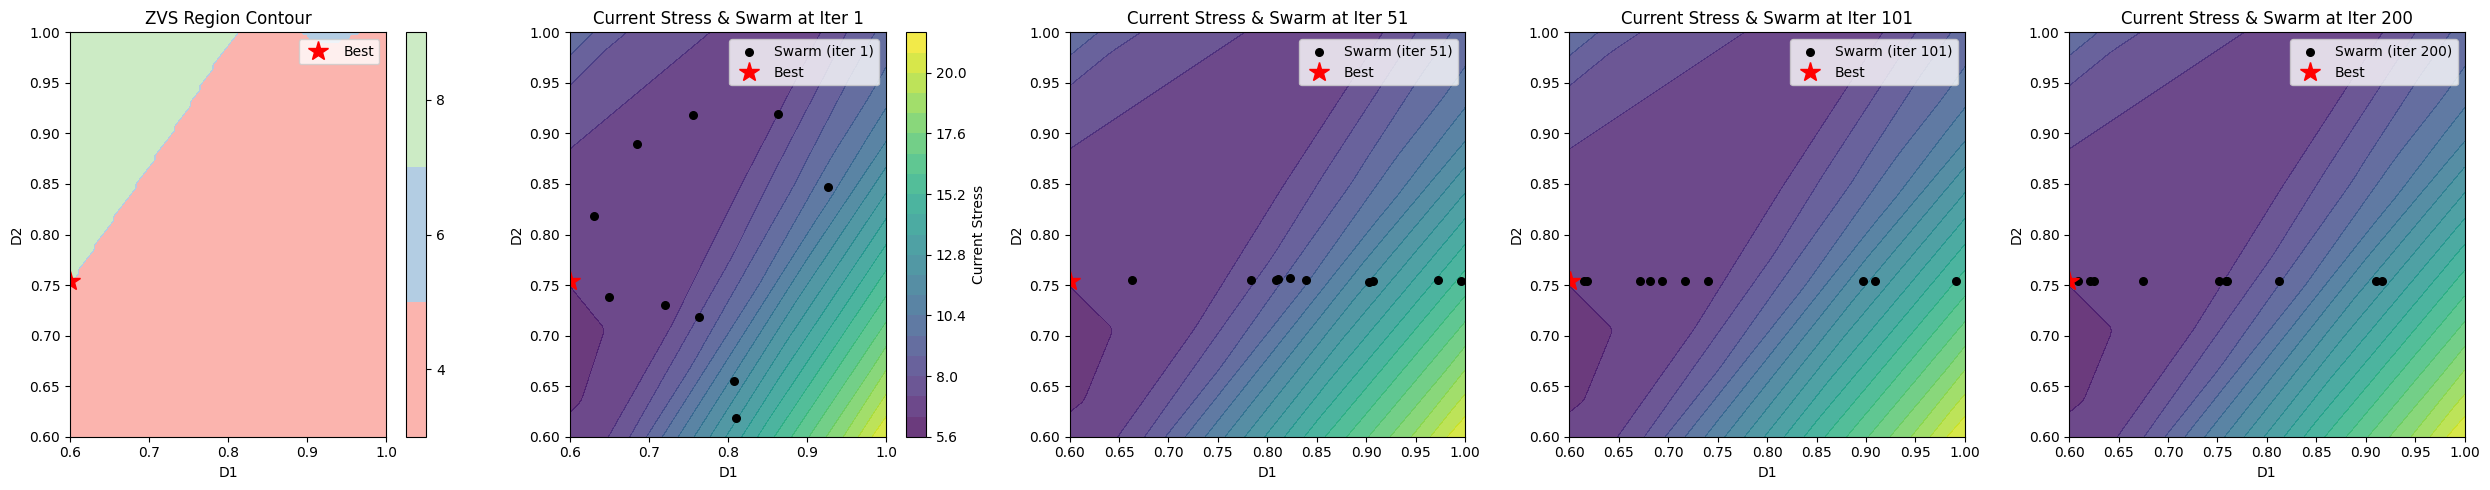

Optimized current stress: 6.4062
Target ZVS devices: 8


In [12]:
# @title  {"form-width":"30%"}
# @markdown ### Comments
# @markdown
# @markdown - **Observe the impacts of PSO hyperparameters** on algorithm convergence.
# @markdown - **Convergence:** In this context, all particles converge to a fixed location.
# --- Plotting Section ---
# 1st subfigure: contour of ZVS
# The rest: current stress contours at selected optimization steps

# Prepare grid for contour plots
d1_vals = np.linspace(d1_min, d1_max, 100)
d2_vals = np.linspace(d2_min, d2_max, 100)
D1_grid, D2_grid = np.meshgrid(d1_vals, d2_vals)
ZVS_grid = np.zeros_like(D1_grid)
CurrentStress_grid = np.zeros_like(D1_grid)

# Compute ZVS grid (for 1st subplot)
model_NN_classification.eval()
with torch.no_grad():
    for i in range(D1_grid.shape[0]):
        for j in range(D1_grid.shape[1]):
            X_grid = np.array([[P_fixed, Vref_fixed, D1_grid[i, j], D2_grid[i, j]]])
            X_grid_scaled = scaler.transform(X_grid)
            X_grid_tensor = torch.FloatTensor(X_grid_scaled)
            zvs_output = model_NN_classification(X_grid_tensor)
            zvs_pred = torch.argmax(zvs_output, dim=1).item()
            zvs_mapping = {0: 4, 1: 6, 2: 8}
            ZVS_grid[i, j] = zvs_mapping[zvs_pred]

# Compute current stress grid (for later subplots)
model_NN_regression.eval()
with torch.no_grad():
    for i in range(D1_grid.shape[0]):
        for j in range(D1_grid.shape[1]):
            X_grid = np.array([[P_fixed, Vref_fixed, D1_grid[i, j], D2_grid[i, j]]])
            X_grid_scaled = scaler.transform(X_grid)
            X_grid_tensor = torch.FloatTensor(X_grid_scaled)
            current_stress = model_NN_regression(X_grid_tensor).squeeze().item()
            CurrentStress_grid[i, j] = current_stress

# Choose which iterations to plot (e.g., 1st, 25th, 50th, last)
plot_steps = [0, n_iters//4, n_iters//2, n_iters-1]
n_plots = 1 + len(plot_steps)

fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))

# 1st subplot: ZVS contour
ax = axes[0]
contour = ax.contourf(D1_grid, D2_grid, ZVS_grid, levels=[3,5,7,9], colors=['#fbb4ae','#b3cde3','#ccebc5'])
cbar = fig.colorbar(contour, ax=ax, ticks=[4,6,8])
ax.set_title('ZVS Region Contour')
ax.set_xlabel('D1')
ax.set_ylabel('D2')
ax.set_xlim([d1_min, d1_max])
ax.set_ylim([d2_min, d2_max])

# Overlay the best position
ax.plot(best_pos[0], best_pos[1], 'r*', markersize=15, label='Best')
ax.legend()

# Next subplots: current stress contour + swarm positions at selected steps
for idx, step in enumerate(plot_steps):
    ax = axes[idx+1]
    cs_contour = ax.contourf(D1_grid, D2_grid, CurrentStress_grid, levels=20, cmap='viridis', alpha=0.8)
    if idx == 0:
        # Add colorbar only to the first current stress subplot
        fig.colorbar(cs_contour, ax=ax, label='Current Stress')
    swarm_pos = swarm_history[step]
    ax.scatter(swarm_pos[:,0], swarm_pos[:,1], c='k', s=30, label=f'Swarm (iter {step+1})')
    ax.plot(best_pos[0], best_pos[1], 'r*', markersize=15, label='Best')
    ax.set_title(f'Current Stress & Swarm at Iter {step+1}')
    ax.set_xlabel('D1')
    ax.set_ylabel('D2')
    ax.set_xlim([d1_min, d1_max])
    ax.set_ylim([d2_min, d2_max])
    ax.legend()

plt.tight_layout()
plt.show()

# Evaluate the best solution
X_best = np.array([[P_fixed, Vref_fixed, best_pos[0], best_pos[1]]])
X_best_scaled = scaler.transform(X_best)
X_best_tensor = torch.FloatTensor(X_best_scaled)

model_NN_regression.eval()
model_NN_classification.eval()
with torch.no_grad():
    best_current_stress = model_NN_regression(X_best_tensor).item()
    best_zvs_prediction = model_NN_classification(X_best_tensor).argmax(dim=1).item()
    zvs_mapping = {0: 4, 1: 6, 2: 8}
    best_zvs_prediction = zvs_mapping[best_zvs_prediction]

print(f"Optimized current stress: {best_current_stress:.4f}")
print(f"Target ZVS devices: {best_zvs_prediction}")